# Project Simulation Code for Establishing Mortality Threshold of Resuscitative Thoracotomy (RT)

## Import Python Packages

In [190]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

## Generate Mock Data

In [268]:
# Create mock data

mortality = np.sort(np.random.randint(2, size=10000)) # generate mortality data, 0 = Survived, 1 = Deceased
age       = np.hstack((np.random.randint(1,30, size=2500), np.random.randint(30,60,5000), np.random.randint(60,100,2500))) # generate age data
sex       = np.random.randint(2, size=10000) # generate sex data, 0 = female, 1 = male
moi       = np.random.randint(2, size=10000) # generate moi data, 0 = blunt, 1 = penetrating
sbp       = np.hstack((np.random.randint(140,200,2500), np.random.randint(100, 140, size=5000), np.random.randint(50,100,2500))) # generate sbp data
hr        = np.sort(np.random.randint(0, 160, size=10000))[::-1] # generate HR data
rr        = np.sort(np.random.randint(0, 40, size=10000))[::-1] # generate RR data
so2       = np.sort(np.random.randint(70, 100, size=10000))[::-1] # generate SpO2% data

# Combine data frames together

data = np.vstack([age, sex, moi, sbp, hr, rr, so2, mortality]).T
data = pd.DataFrame(data, columns=['Age', 'Sex', 'MOI', 'SBP', 'HR', ' RR','SO2%','Mortality'])

# Display data sample 

pd.set_option('display.max_rows', 6)
display(data)

,Age,Sex,MOI,SBP,HR,RR,SO2%,Mortality
0,7,0,0,167,159,39,99,0
1,1,0,1,154,159,39,99,0
2,29,0,1,156,159,39,99,0
...,...,...,...,...,...,...,...,...
9997,97,1,1,95,0,0,70,1
9998,85,0,1,56,0,0,70,1
9999,98,0,1,62,0,0,70,1


## Plot Distribution of Patients Age

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


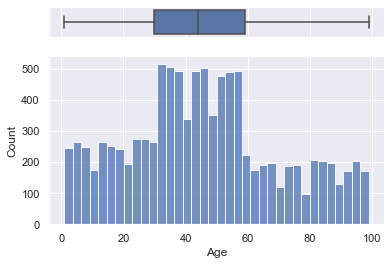

In [269]:
# Show distributions of each data category

sns.set_theme(style="darkgrid") # Set color theme
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data["Age"], orient="h", ax=ax_box)
sns.histplot(data=data["Age"], ax=ax_hist)
ax_box.set(xlabel='')
plt.show()


## Data Exploration for Trends

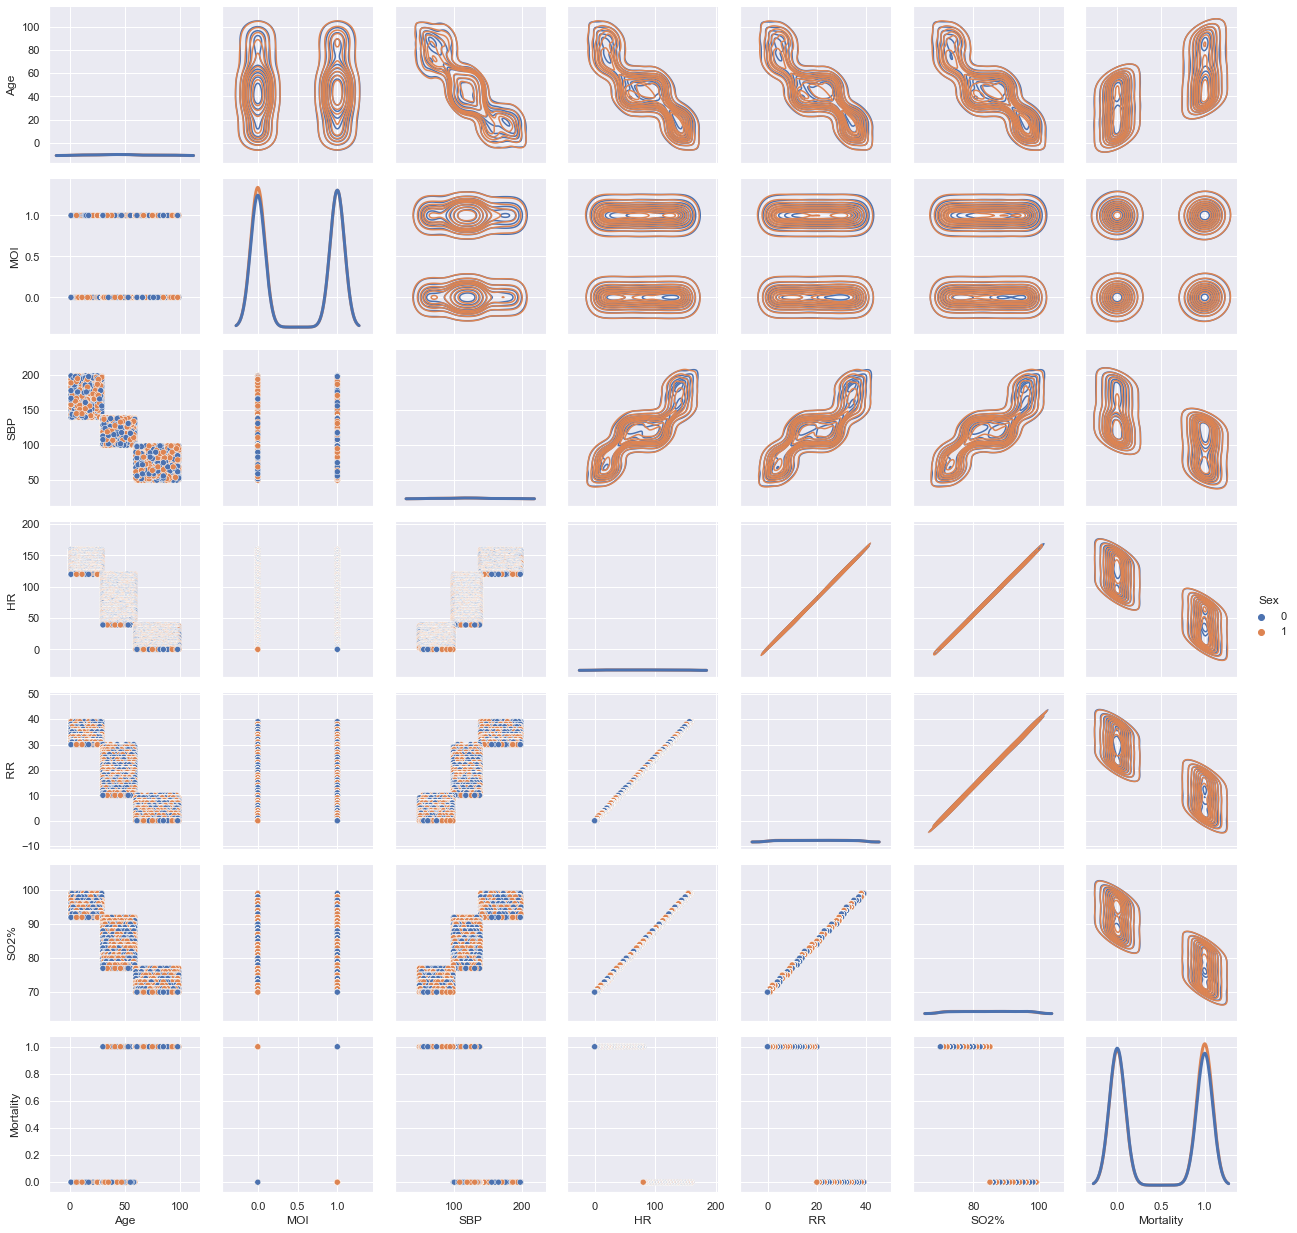

In [270]:
g = sns.PairGrid(data, hue="Sex")
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.add_legend()
plt.show()

## Assign Patients to Age Bin and Show Number of Patients In Each

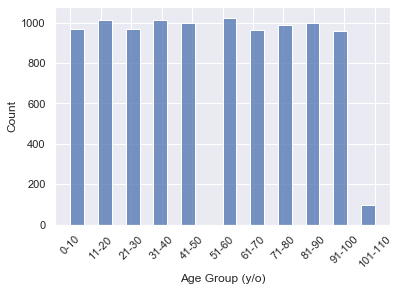

In [146]:
# Bin the data by age in 10 year chunks

age_list = list(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100','101-110'])
bins = np.linspace(0,100,11)
binned_data = np.digitize(x=data['Age'], bins=bins) # returns list of int for each bin
data['Bins'] = binned_data
data = data.sort_values(by=['Age'])
avg_mortality_all = np.mean(data['Mortality'])
std_mortality_all = np.std(data['Mortality'])

mortality_df = pd.DataFrame(columns=['Bin', 'Average Mortality'])
mortality_scaler = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0, 9.0, 17.0, 33.0] # generate scale to make curve exponential, would not use in actual code

for i in np.unique(binned_data):
    df = data.loc[data['Bins'] == i]
    avg_mortality = np.mean(df['Mortality']) * mortality_scaler[i-1]
    df2 = pd.DataFrame([[i, avg_mortality]], columns = ['Bin', 'Average Mortality'])
    mortality_df = mortality_df.append(df2)
mortality_df['Age Range (y/o)'] = age_list
mortality_df['Average Mortality'] = mortality_df['Average Mortality'].div(np.max(mortality_df['Average Mortality'])) # forces mortality into scale between 0-1, not part of actual code just mock data

g = sns.histplot(data=data["Bins"])
g.set_xticks(range(1,12))
g.set_xticklabels(age_list)
plt.xticks(rotation=45)
plt.xlabel('Age Group (y/o)')
ax_box.set(xlabel='')
plt.show()

## Plot Relationship of Average Mortality vs. Age Range

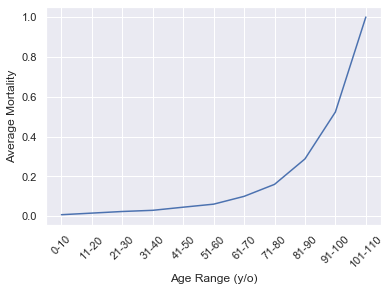

In [147]:
# Plot data as age vs mortality rate

g = sns.lineplot(data=mortality_df, x='Age Range (y/o)', y='Average Mortality', )
plt.xticks(rotation=45)
plt.show()

## Create Threshold for Mortality at the Mean Mortality by Age Group + 2SD

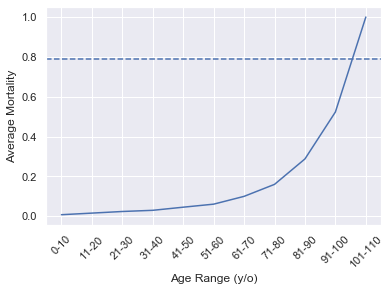

In [148]:
# Plot with threshold set at x +/- 2SD

simple_threshold = np.mean(mortality_df['Average Mortality']) + 2*np.std(mortality_df['Average Mortality']) # using 0.8 mulitplier for average just to make threshold be below, for real scenarion this would not be the 
g = sns.lineplot(data=mortality_df, x='Age Range (y/o)', y='Average Mortality')
plt.xticks(rotation=45)
g.axhline(simple_threshold, ls='--')
plt.show()

## Logistic Regression ML (Possible future/ separate project, below)

,Age,Mortality,Bins,Sex,MOI,SBP,HR,RR
2883,28,0,3,1,1,139,0,39
9619,93,0,10,0,1,139,0,39
7895,82,0,9,0,1,139,0,39
...,...,...,...,...,...,...,...,...
6121,29,1,3,0,0,40,0,0
3399,91,1,10,0,0,40,0,0
1602,28,1,3,1,0,40,0,0


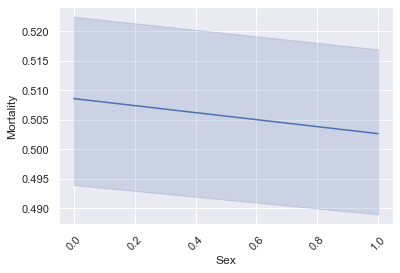

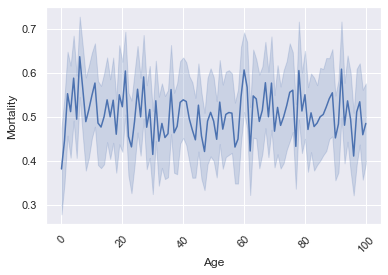

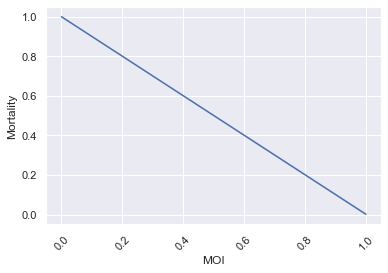

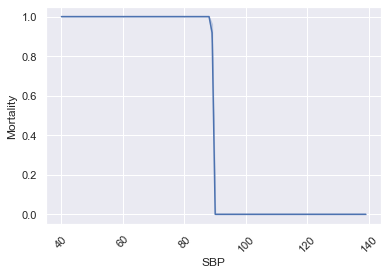

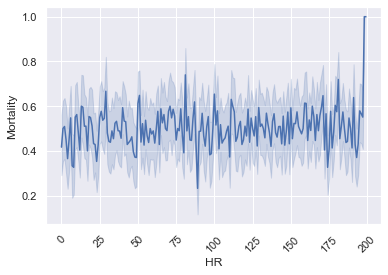

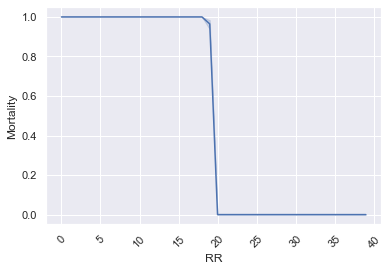

In [222]:
# Add additional parameters to data

data = data.sort_values(['Mortality'])

data['Sex'] = np.random.randint(0,2,10000) # 0 = female, 1 = male
data['MOI'] = np.sort(np.random.randint(0,2,10000))[::-1] # 0 = blunt, 1 = penetrating
data['SBP'] = np.sort(np.random.randint(40, 140, 10000))[::-1] # Systolic BP
data['HR']  = np.append(np.sort(np.random.randint(0, 200, 5000)), np.sort(np.random.randint(0, 200, 5000))[::-1]) # Heart Rate
data['RR']  = np.sort(np.random.randint(0, 40, 10000))[::-1] # Respiratory Rate
display(data)

variables_to_use = ['Age', 'Sex', 'MOI', 'SBP', 'HR', 'RR']

g = sns.lineplot(data=data, x='Sex', y='Mortality')
plt.xticks(rotation=45)
plt.show()

g = sns.lineplot(data=data, x='Age', y='Mortality')
plt.xticks(rotation=45)
plt.show()

g = sns.lineplot(data=data, x='MOI', y='Mortality')
plt.xticks(rotation=45)
plt.show()

g = sns.lineplot(data=data, x='SBP', y='Mortality')
plt.xticks(rotation=45)
plt.show()

g = sns.lineplot(data=data, x='HR', y='Mortality')
plt.xticks(rotation=45)
plt.show()

g = sns.lineplot(data=data, x='RR', y='Mortality')
plt.xticks(rotation=45)
plt.show()

In [232]:
# Set sample proportion parameters
perc_train        = 0.80 # proportion of samples to be used in training
perc_val          = 0.1
perc_test         = 0.1

data = data.sample(frac=1) # shuffle data

# perc_train, perc_val, perc_test sum must equal <1.0

num_train_samples = int(np.shape(data)[0]*perc_train)
num_val_samples   = int(np.shape(data)[0]*perc_val)
num_test_samples  = int(np.shape(data)[0]*perc_test)

# Make Training, Validation and Test Splits

X_train = data[variables_to_use][:num_train_samples]
X_val   = data[variables_to_use][num_train_samples:num_train_samples+num_val_samples]
X_test  = data[variables_to_use][num_train_samples+num_val_samples:num_train_samples+num_val_samples+num_test_samples]
y_train = data['Mortality'][:num_train_samples]
y_val   = data['Mortality'][num_train_samples:num_train_samples+num_val_samples]
y_test  = data['Mortality'][num_train_samples+num_val_samples:num_train_samples+num_val_samples+num_test_samples]

# Try logistic regression on data without binning of age
LogReg = LogisticRegression(random_state=0, penalty='l2', C=0.1, max_iter=1000 ).fit(X_train,y_train) # LogisticRegression Model Training

y_val_preds  = LogReg.predict(X_val)
y_test_preds = LogReg.predict(X_test)

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [233]:
# Generate Confusion Matrices

cnf_matrix = metrics.confusion_matrix(y_test, y_val_preds)

Text(0.5, 257.44, 'Predicted label')

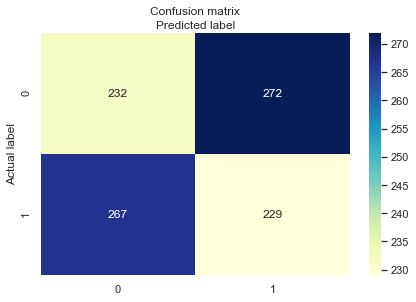

In [234]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [237]:
target_names = ['Alive', 'Deceased']
print(classification_report(y_test, y_val_preds, target_names=target_names))

              precision    recall  f1-score   support

       Alive       0.46      0.46      0.46       504
    Deceased       0.46      0.46      0.46       496

    accuracy                           0.46      1000
   macro avg       0.46      0.46      0.46      1000
weighted avg       0.46      0.46      0.46      1000



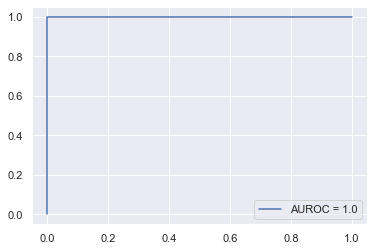

In [238]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUROC = "+str(auc))
plt.legend(loc=4)
plt.show()